<a href="https://colab.research.google.com/github/valerio-unifei/ECOM09A/blob/main/ECOM09A_2024_1_Atividade_2_Etapa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECOM09A Atividade 2 Etapa 2

(24/05/2024) Adaptar o notebook:

https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy

para classificação das categorias via a tokenização das notícias


## Base de dados de artigos da Folha UOL

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'marlesson/news-of-the-site-folhauol'
!unzip -qq news-of-the-site-folhauol.zip
!rm news-of-the-site-folhauol.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 88% 165M/187M [00:02<00:00, 107MB/s] 
100% 187M/187M [00:02<00:00, 89.9MB/s]


### Carregando os artigos do jornal

In [ ]:
import pandas as pd
df=pd.read_csv('articles.csv',encoding="utf8")
print('(linhas, colunas):',df.shape)
print('Linhas:',len(df))
df.drop_duplicates(subset=["text"],inplace=True)
print('Removendo duplicadas em "text":',len(df))
df.drop(['subcategory','link','date'],axis=1,inplace=True)
print('Removendo subcategory')
df.dropna(inplace=True)
print('Removendo nulos:',len(df))
df.reset_index(drop=True,inplace=True)
print('Resetando index')
df.head()

(linhas, colunas): (167053, 6)
Linhas: 167053
Removendo duplicadas em "text": 165902
Removendo subcategory
Removendo nulos: 165901
Resetando index


,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [ ]:
df['category'].value_counts()

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

In [ ]:
df['category'].value_counts()[:10]

category
poder             22005
colunas           21499
mercado           20936
esporte           19723
mundo             17123
cotidiano         16952
ilustrada         15604
opiniao            4523
paineldoleitor     4008
saopaulo           3953
Name: count, dtype: int64

In [ ]:
df = df[df['category'].isin(list(df['category'].value_counts()[:7].index))]

df['target'] = df['category'].replace('guia-de-livros-discos-filmes','guia-de-livros-filmes-discos')
alvo, valores = pd.factorize(df['target'],sort=True)
df['target'] = alvo
print('Novo tamanho:',len(df))
print(list(enumerate(valores)))

Novo tamanho: 133842
[(0, 'colunas'), (1, 'cotidiano'), (2, 'esporte'), (3, 'ilustrada'), (4, 'mercado'), (5, 'mundo'), (6, 'poder')]


## Adaptando Notebook

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [ ]:
nltk.download('stopwords')

stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Limpeza de Texto

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

## WORDCLOUD

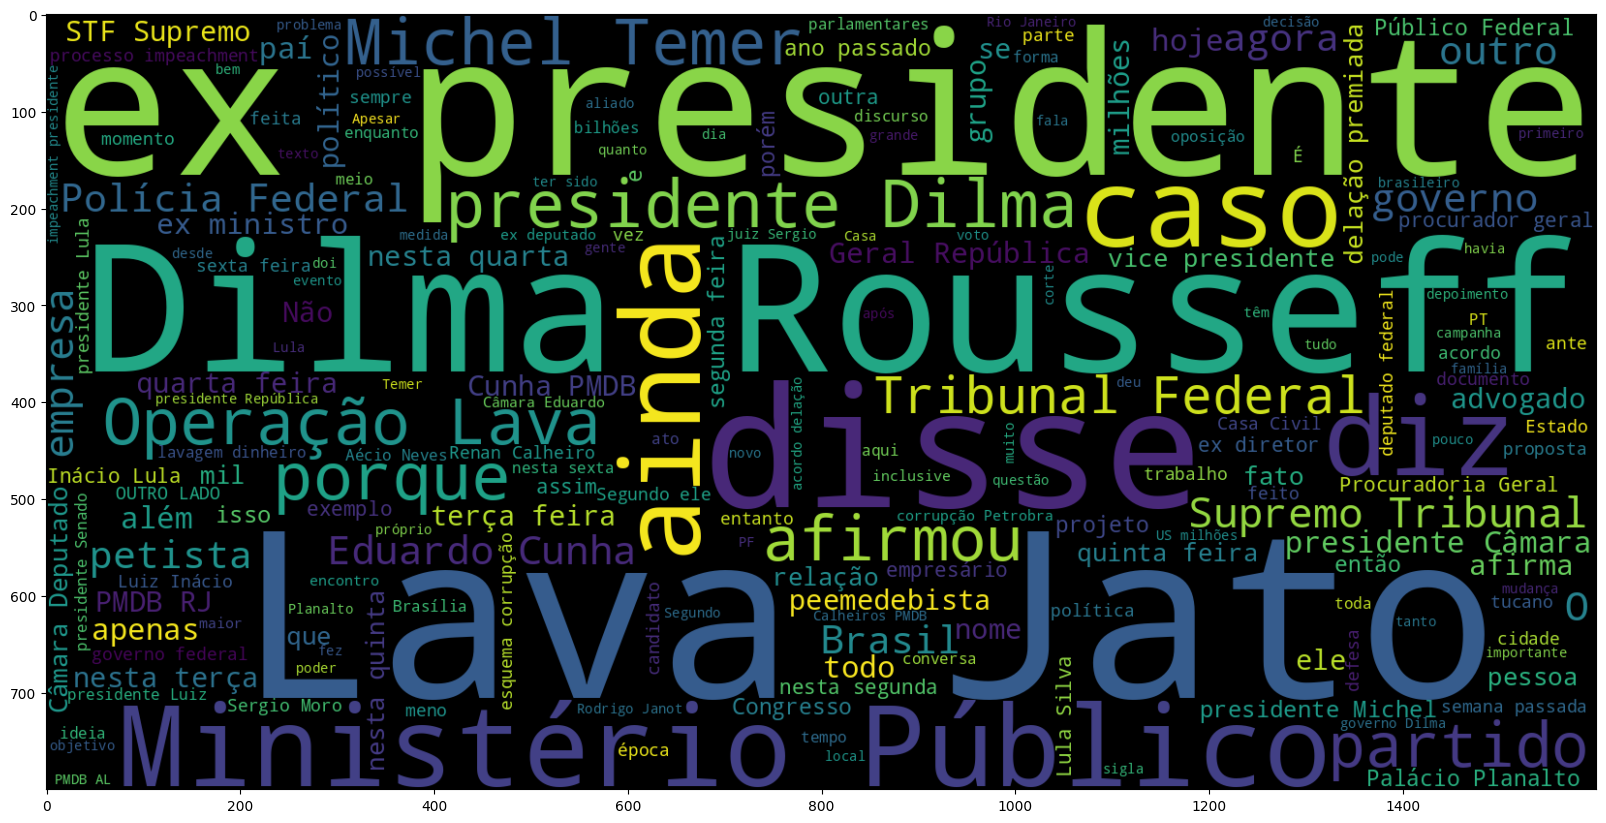

In [ ]:
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 200 , width = 1600 , height = 800).generate(" ".join(df[df['category']=='poder']['text']))

_ = plt.imshow(wc , interpolation = 'bilinear')

## Converting text to format acceptable by gensim

In [ ]:
words = []
for i in df.text.values:
    words.append(i.split())
print(words[:2])

[['possibilidade', 'condenação', 'impedir', 'candidatura', '2018,', 'ex-presidente', 'Luiz', 'Inácio', 'Lula', 'Silva', 'fez,', 'nesta', 'segunda', '(9),', 'discurso', 'inflamado', 'contra', 'Lava', 'Jato,', 'disse', 'saber', '"lascado",', 'exigiu', 'pedido', 'desculpas', 'juiz', 'Sergio', 'Moro', 'afirmou', 'que,', 'disputa', 'Planalto,', 'cabo', 'eleitoral', 'expressivo', 'sucessão', 'Michel', 'Temer.', 'Segundo', 'petista,', 'réu', 'sete', 'ações', 'penais,', 'objetivo', 'Moro', 'impedir', 'candidatura', 'ano', 'vem,', 'desidratando-o,', 'inclusive,', 'apoio', 'nome', 'alternativo,', 'ex-prefeito', 'Paulo', 'Fernando', 'Haddad', '(PT),', 'caso', 'possa', 'concorrer', 'Presidência.', '"Eu', 'sei', 'tô', 'lascado,', 'todo', 'dia', 'processo.', 'quero', 'Moro', 'absolva,', 'quero', 'peça', 'desculpas",', 'disse', 'Lula', 'durante', 'seminário', 'sobre', 'educação', 'Brasília.', '"Eles', '[investigadores]', 'chegam', 'dizer:', "'Ah,", 'Lula', 'candidato,', 'vai', 'ter', 'força', 'cabo',

In [ ]:
import gensim
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = words, max_vocab_size=EMBEDDING_DIM, window = 5, min_count = 1)

In [ ]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_weight_matrix(model, vocab):
  # total vocabulary size plus 0 for unknown words
  vocab_size = len(vocab) + 1
  # define weight matrix dimensions with all 0
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  # step vocab, store vectors using the Tokenizer's integer mapping
  for word, i in vocab.items():
      weight_matrix[i] = model[word]
  return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

TypeError: 'Word2Vec' object is not subscriptable

## Treinando Modelo Word2Vec

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))


saidas = len(valores)
#LSTM
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(saidas, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['acc','f1'])

del embedding_vectors

model.summary()